<a name='0'></a>

# Going Deeper with Convolutions - GoogLeNet

GoogLeNet architecture won the Imagenet Challenge(classification and detection) of 2014 with a top-5 error rate of `6.7%`. 

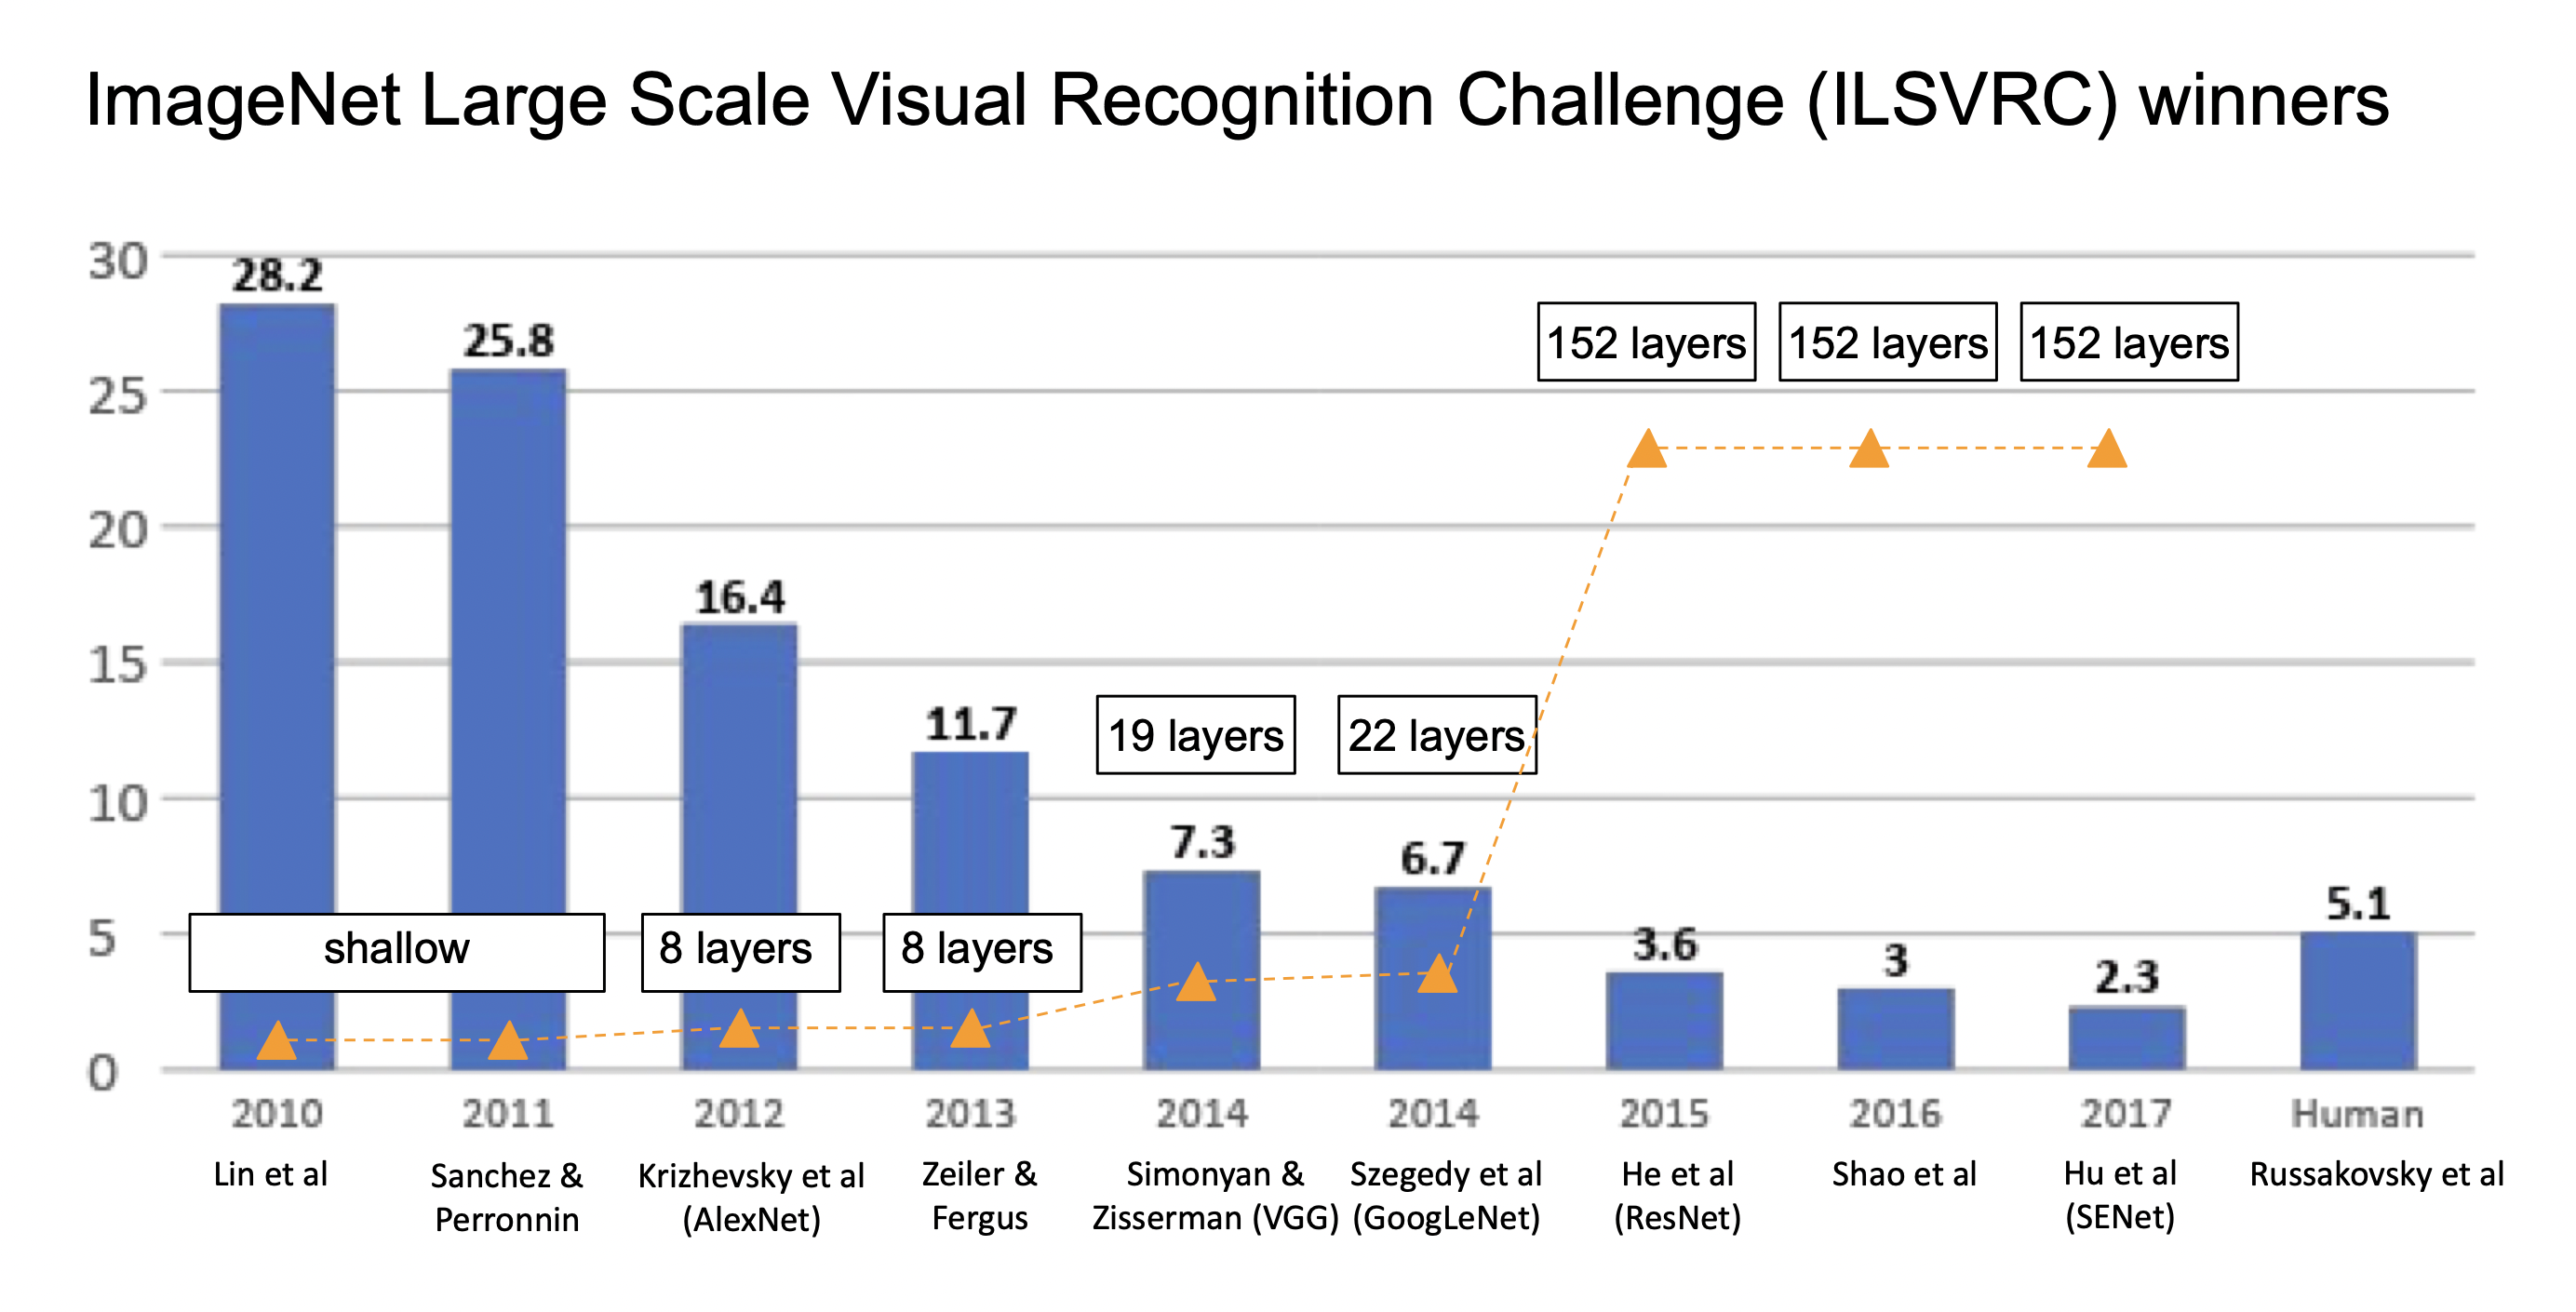

*Image: ImageNet Challenge, 2010-2017. Taken from CS231n, CNNs for Visual Recognition.*


### What's in here: 

  * [1. Introduction](#1)
  * [2. GoogLeNet Architecture](#2)
  * [3. Inception Module](#3)
  * [4. GoogLeNet Implementation](#4)
  * [5. Final Notes](#6)



<a name='1'></a>

## 1. Introduction

GoogLeNet has 22 layers, 16 layers more than AlexNet, and 8 layers than VGG-19. Despite having more layers than AlexNet and VGG, it actually has fewer parameters and memory usage. To put that into perspective, GoogLeNet has only 5M parameters, 12 times fewer than AlexNet, and 27 times fewer than VGG-16. GoogleNet again proved that depth(large number of layers and units) is essential for performance.

As its [paper](https://arxiv.org/abs/1409.4842) shows, the most notable thing about GoogLeNet is that it introduced new design principles that kept the computation budget low compared to former architectures. That can be advantageous to applications that require low inference time such as mobile and embedded devices. 

The key design component of the GoogLeNet is inception module. We will talk about Inception module in the following sections.

<a name='2'></a>
## 2. GoogLeNet Architecture

GoogLeNet is a deep network that has 22 layers with learnable parameters, and 27 if we count pooling layers. Pooling layers don't have parameters. 


GoogLeNet is made of 4 main parts: 

* The downsampling block at the input or the stem of the network. This is made of 3 convolutional layers and 1 maxpooling layer. The first convolutional layer has a kernel size of 7x7, stride 2, second with a kernel size of 1x1 and third one with again 3X3 kernel size. Maxpooling layer is right after the first convolutional layer, and it has a pool size of 3 and stride of 2.

* Inception modules that are the main building block of the whole GoogLeNet architecture. The name inception was mimicked from the Inception movie and the meme `We need to go deeper`.

<!-- !['deep'](https://i.kym-cdn.com/photos/images/newsfeed/000/531/557/a88.jpg) -->

* The main classification head that contains average pooling layer of 7 pool size, a dropout layer of 0.4 dropout ratio, and 1 fully connected layer with 1000 units(corresponding to imagenet categories) and softmax activation function.

* 2 auxiliary classifiers: Each contains average pooling layer of 5 pool size and stride 3, a convolutional layer of 1x1 kernel size and 128 filters, a fully connected layer of 1024 units, a dropout layer of 0.7 dropout ratio, a fully connected layer 1ith 1000 units and softmax activation functions. During the training, the loss of auxiliary classifiers are added to the total loss of the network, but they are discarded at the inference time. We will omit the auxiliary classifiers in our implementation.




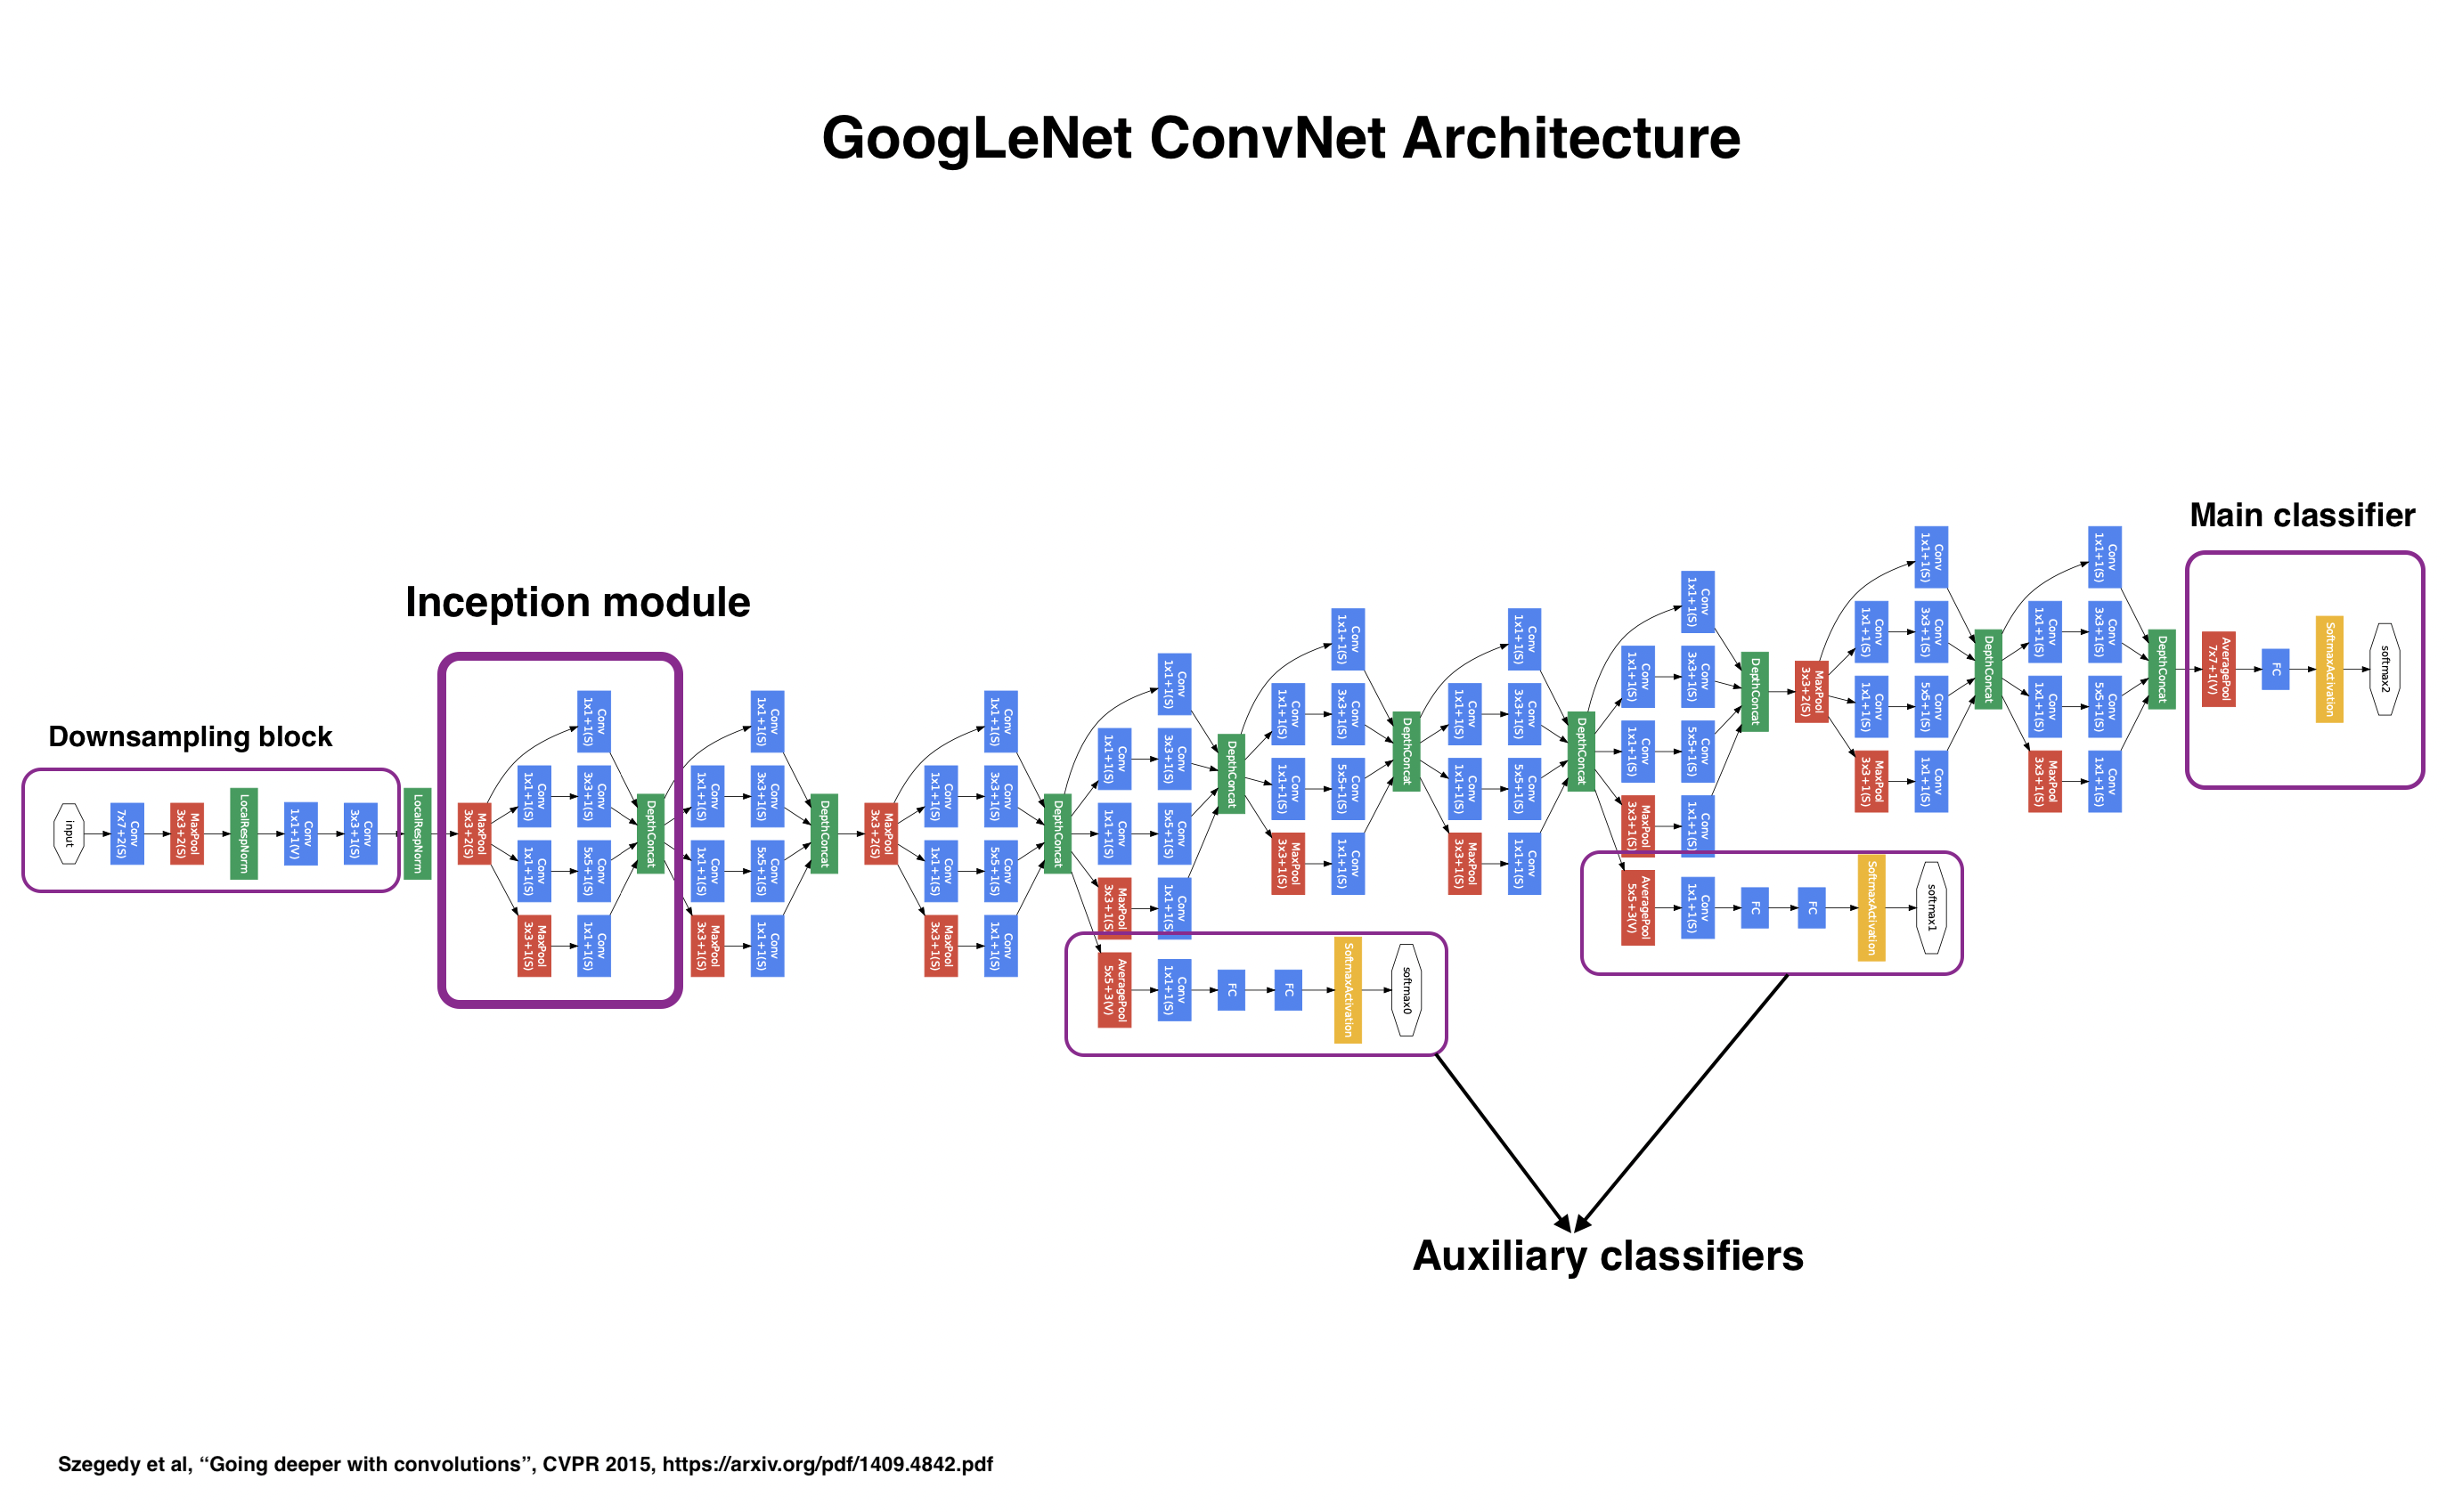

Below table summarize the GoogLeNet layers and their output. 

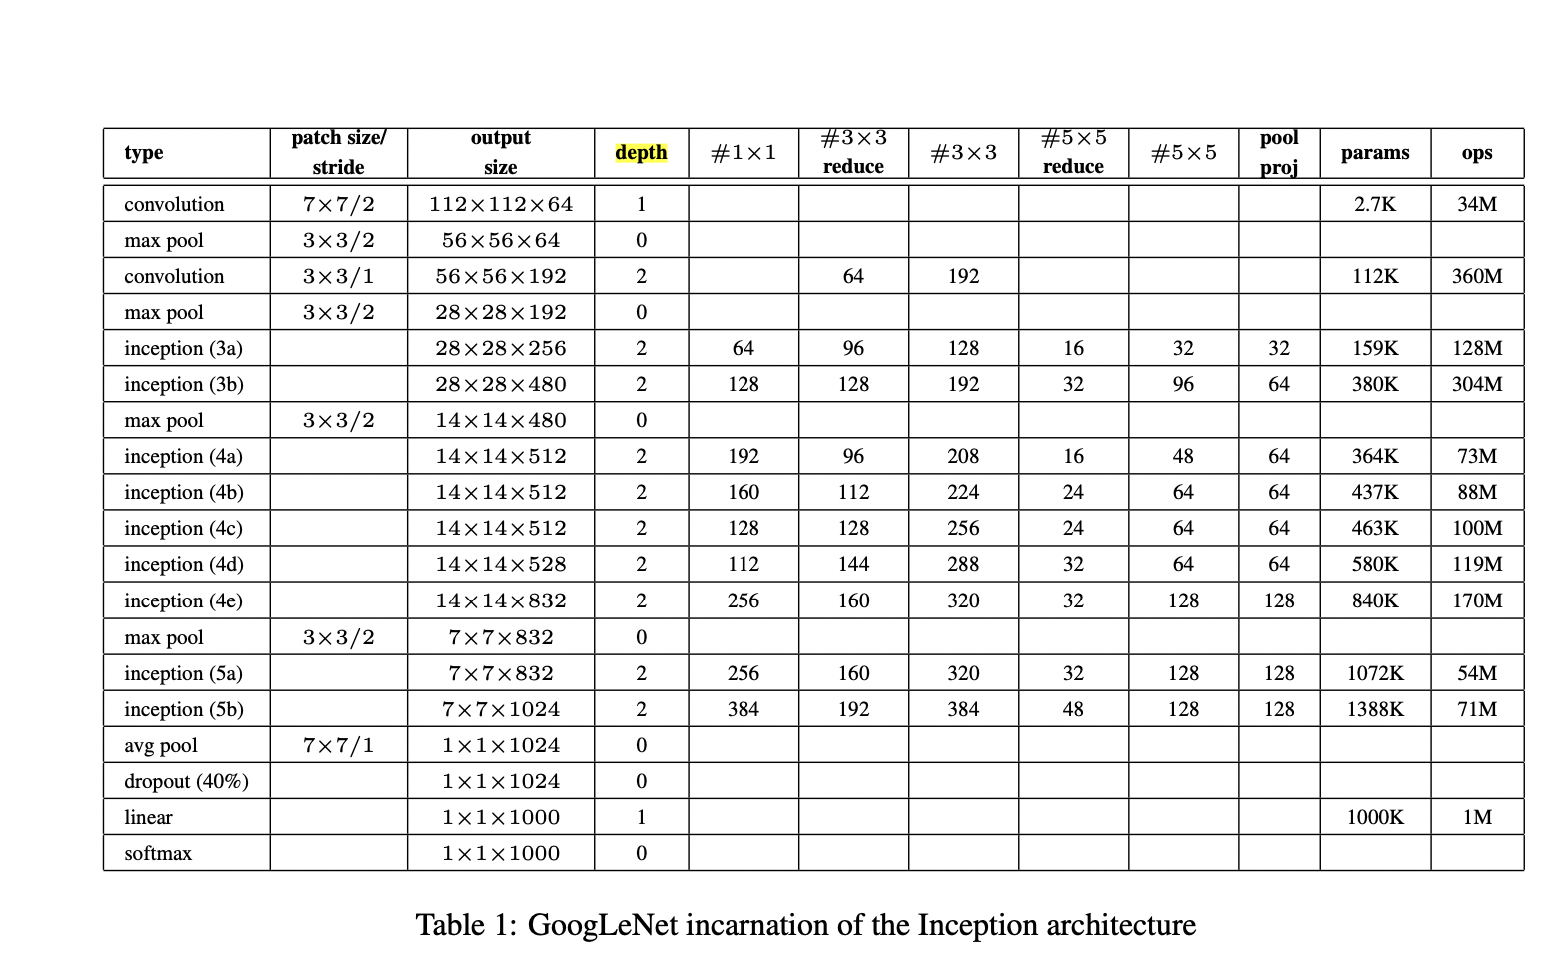

<a name='3'></a>

## 3. Inception Module

Inception is the main building block of the whole GoogLeNet architecture. Inception module is a local construction that are stacked on top of each other. 

At its bottleneck, it uses 1X1 convolution to reduce the channel dimension. More generally, inception is made of 4 parallel paths that are: 

* The first path is made of one convolutional layer with kernel/filter size of 1x1. 1x1 convolution reduces the channel size.
* The second path has 2 convolutional layers having 1x1 and 3x3 filter size. Again, 1x1 convolution is before 3x3 to reduce the dimension of the input as 3x3 is computationally expensive. 
* The third path has 1x1 and 5x5 convolution layers. 
* The fourth path has a maxpooling layer with pool size of 3 and 1x1 convolution. 


The output of those 4 parallel paths are concatenated. All inception modules in GoogLeNet has the same filter sizes (1x1, 3x3, 5x5). That means the main thing to change is the number of channels in every convolution layer. 

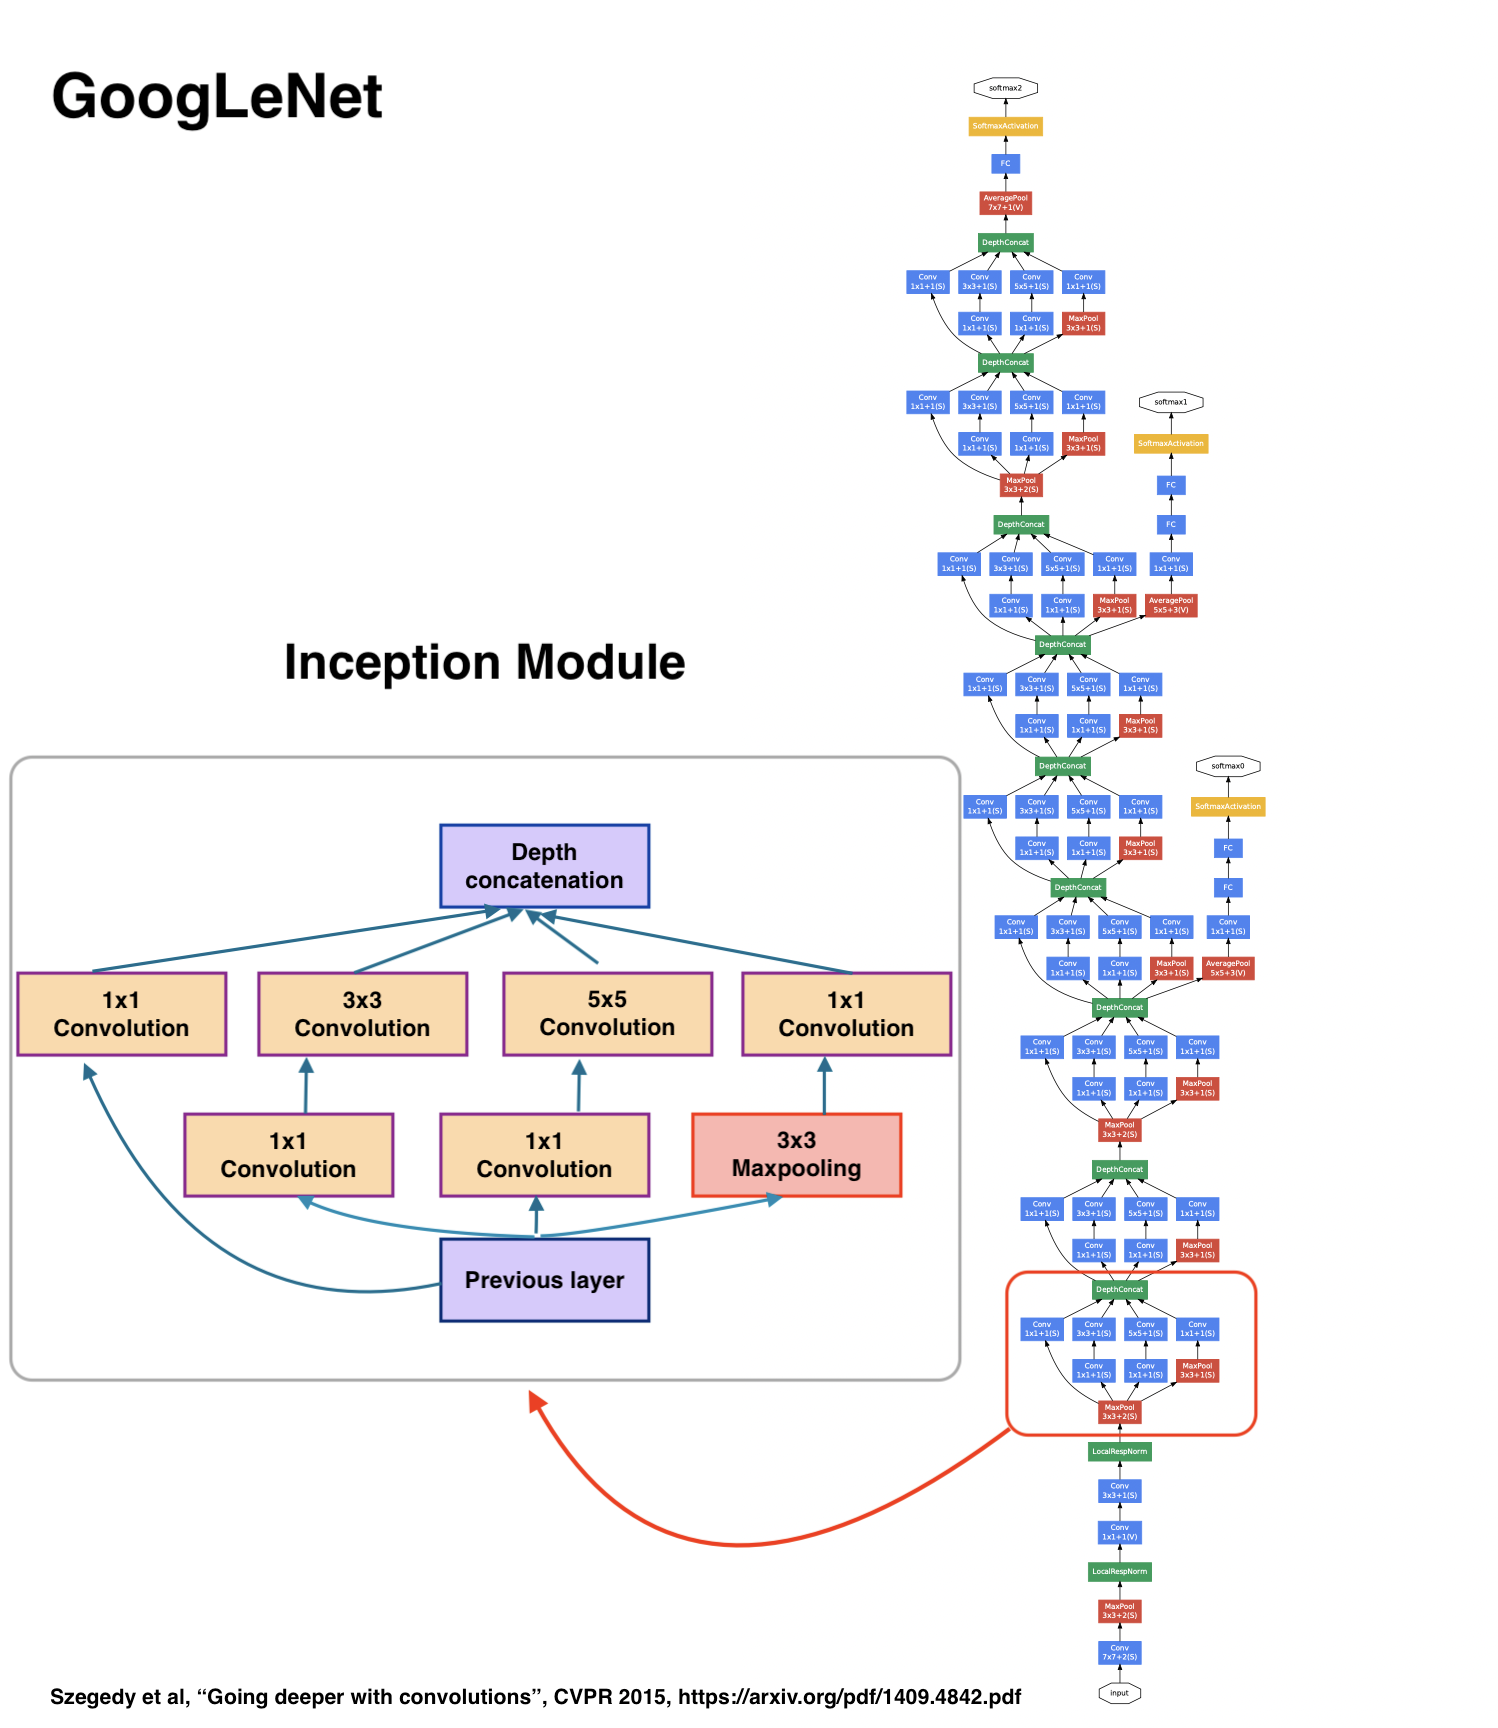

Now that we understand the architecture of the GoogLeNet, let's implement it from scratch.

<a name='4'></a>
## 4. GoogleNet Implementation

### Set up

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, utils

### Inception Module

We will start by implementing the inception module. Recall that it has 4 main parallel paths whose outputs are concatenated together to be fed to the next module. 

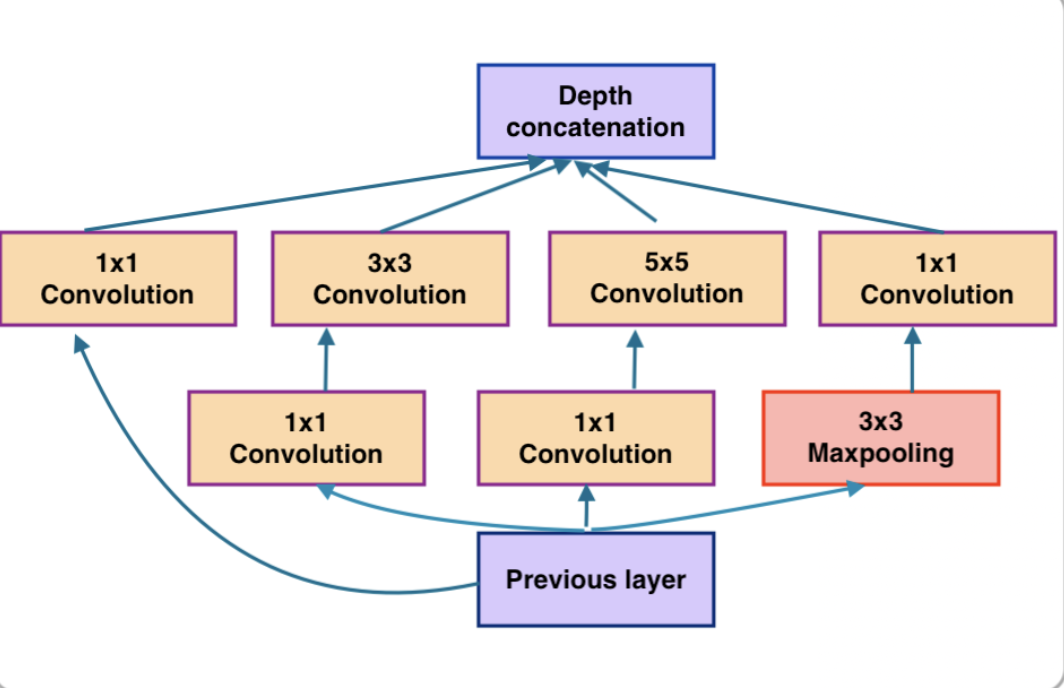

In [2]:
def inception_module(prev, c1, c2, c3, c4):
  """
  prev: previous layer
  c1, c2, c3, c4 are channels/number of filters for 4 parallel paths
  c1: channels for path 1
  c2: a tuple of two channels for path 2
  c3: a tuple of two channels for path 3
  c4: channels for path 1
  """

  # Path 1: 1x1 convolution, c1 channels
  p1 = layers.Conv2D(filters=c1, kernel_size=(1,1), activation='relu')(prev)

  # Path 2: 1x1 convolution with channel c2[0], 3x3 convolution with channel c2[1]
  p2 = layers.Conv2D(filters=c2[0], kernel_size=(1,1), activation='relu')(prev)
  p2 = layers.Conv2D(c2[1], kernel_size=(3,3), activation='relu', padding='same')(p2)

  # Path 3: 1x1 convolution with channel c3[0], 5x5 convolution with channel c3[1]
  p3 = layers.Conv2D(filters=c3[0], kernel_size=(1,1), activation='relu')(prev)
  p3 = layers.Conv2D(filters=c3[1], kernel_size=(5,5), activation='relu', padding='same')(p3)

  # Path 4: maxpooling layer with 3x3 pool size and stride of 1, 1x1 convolution with c4 channels
  p4 = layers.MaxPool2D(pool_size=(3,3), strides=1, padding='same')(prev)
  p4 = layers.Conv2D(filters=c4, kernel_size=(1,1), activation='relu')(p4)

  # Concatenate the outputs of all 4 paths
  output = layers.Concatenate()([p1, p2, p3, p4])

  return output

We can test if what we did is correct by providing the input image of a given shape to a single inception module. 

In [3]:
input = layers.Input(shape=[224,224,3], name='Input')
output = inception_module(input, 6, (6,6), (6,6), 6)

inception = tf.keras.Model(input, output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 6)  24          ['Input[0][0]']                  
                                                                                                  
 conv2d_3 (Conv2D)              (None, 224, 224, 6)  24          ['Input[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 224, 224, 3)  0           ['Input[0][0]']              

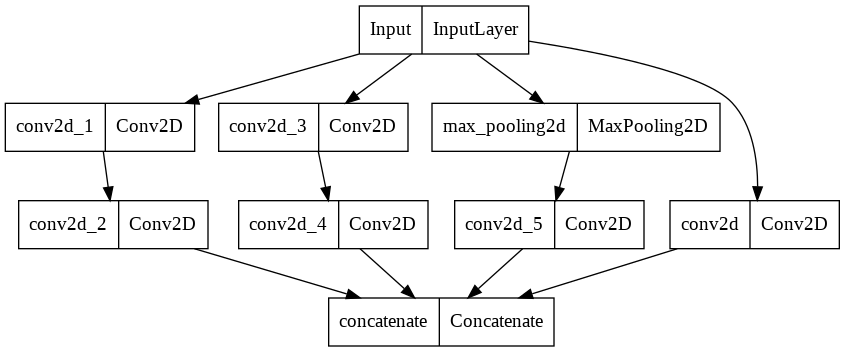

In [5]:
inception.summary()

utils.plot_model(inception)

### Building the Rest of GoogLeNet

After implementing the Inception module, we can now put all parts of the GoogleNet together. 

Here the flow of the GoogLeNet from the input to the output. 

* Building the stem of the network which is made of 7x7 convolution & stride 2, 3x3 maxpooling, 1x1 convolution and 3x3 convolution and 3x3 maxpooling with stride of 2. 

* Stacking two inception modules, one after another. The first module has 64 filters for 1x1 convlution in path 1, 96 for 1x1 convolution and 128 for 3x3 convolution in path 2, 16 for 1x1 convolution and 32 for 5x5 convolution in path 3, and 32 filters in 1x1 convolution in path 4. For simplicity, we can say the inception module 1 have filters in this order: `64, 96, 128, 16, 32, 32`. The filters in the second module are `128, 128, 192, 32, 96, 64`.

* A maxpooling layer of 3x3 pool size and stride 2.
* 5 stacked inception modules with the following respective filters: `[192, 96, 208, 16, 48, 64]`, `[160, 112, 224, 24, 64, 64]`, `[128, 128, 256, 24, 64, 64]`, `[112, 144, 288, 32, 64, 64]`, `[256, 160, 320, 32, 128, 128]`.

* A maxpooling layer of 3x3 pool size and stride 2
* Two stacked inception modules with the following filters: `[256, 160, 320, 32, 128, 128]`, `[384, 192, 384, 48, 128, 128]`
* A final classification head that has average pooling layer of 7x7 pool size and stride 1, a dropout layer of 0.4 drop size, and a fully connected layer of 1000 units (per imagenet but we will use 10 units since we will train it on cifar10 dataset) with softmax activation funtions.

In [8]:
## GoogLeNet

# Input and stem block
# Input shape: 224,224,3
# 7x7 convolution, 3x3 maxpool, 3x3 convolution, 3x3 maxpool


input = layers.Input(shape=[224,224,3])
x = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(input)
x = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)
x = layers.Conv2D(filters=64, kernel_size=(1,1), activation='relu')(x)
x = layers.Conv2D(filters=192, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)

### Two inception modules and maxpool
x = inception_module(x, 64, (96, 128), (16, 32), 32)
x = inception_module(x, 128, (128, 192), (32, 96), 64)
x = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)

### Five inception modules and maxpool
x = inception_module(x, 192, (96, 208), (16, 48), 64)
x = inception_module(x, 160, (112, 224), (24, 64), 64)
x = inception_module(x, 128, (128, 256), (24, 64), 64)
x = inception_module(x, 112, (144, 288), (32, 64), 64)
x = inception_module(x, 256, (160, 320), (32, 128), 128)
x = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)

### Two Inception modules and average pooling layer
x = inception_module(x, 256, (160, 320), (32, 128), 128)
x = inception_module(x, 384, (192, 384), (48, 128), 128)
x = layers.AveragePooling2D(pool_size=(7,7))(x)

### Dropout & classification head

x = layers.Dropout(0.4)(x)
output = layers.Dense(units=10000, activation='softmax')(x)

googlenet = tf.keras.Model(input, output)

We can now see the summary of what we have built. 

In [9]:
googlenet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_63 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_63[0][0]']              
 )                                                                                          

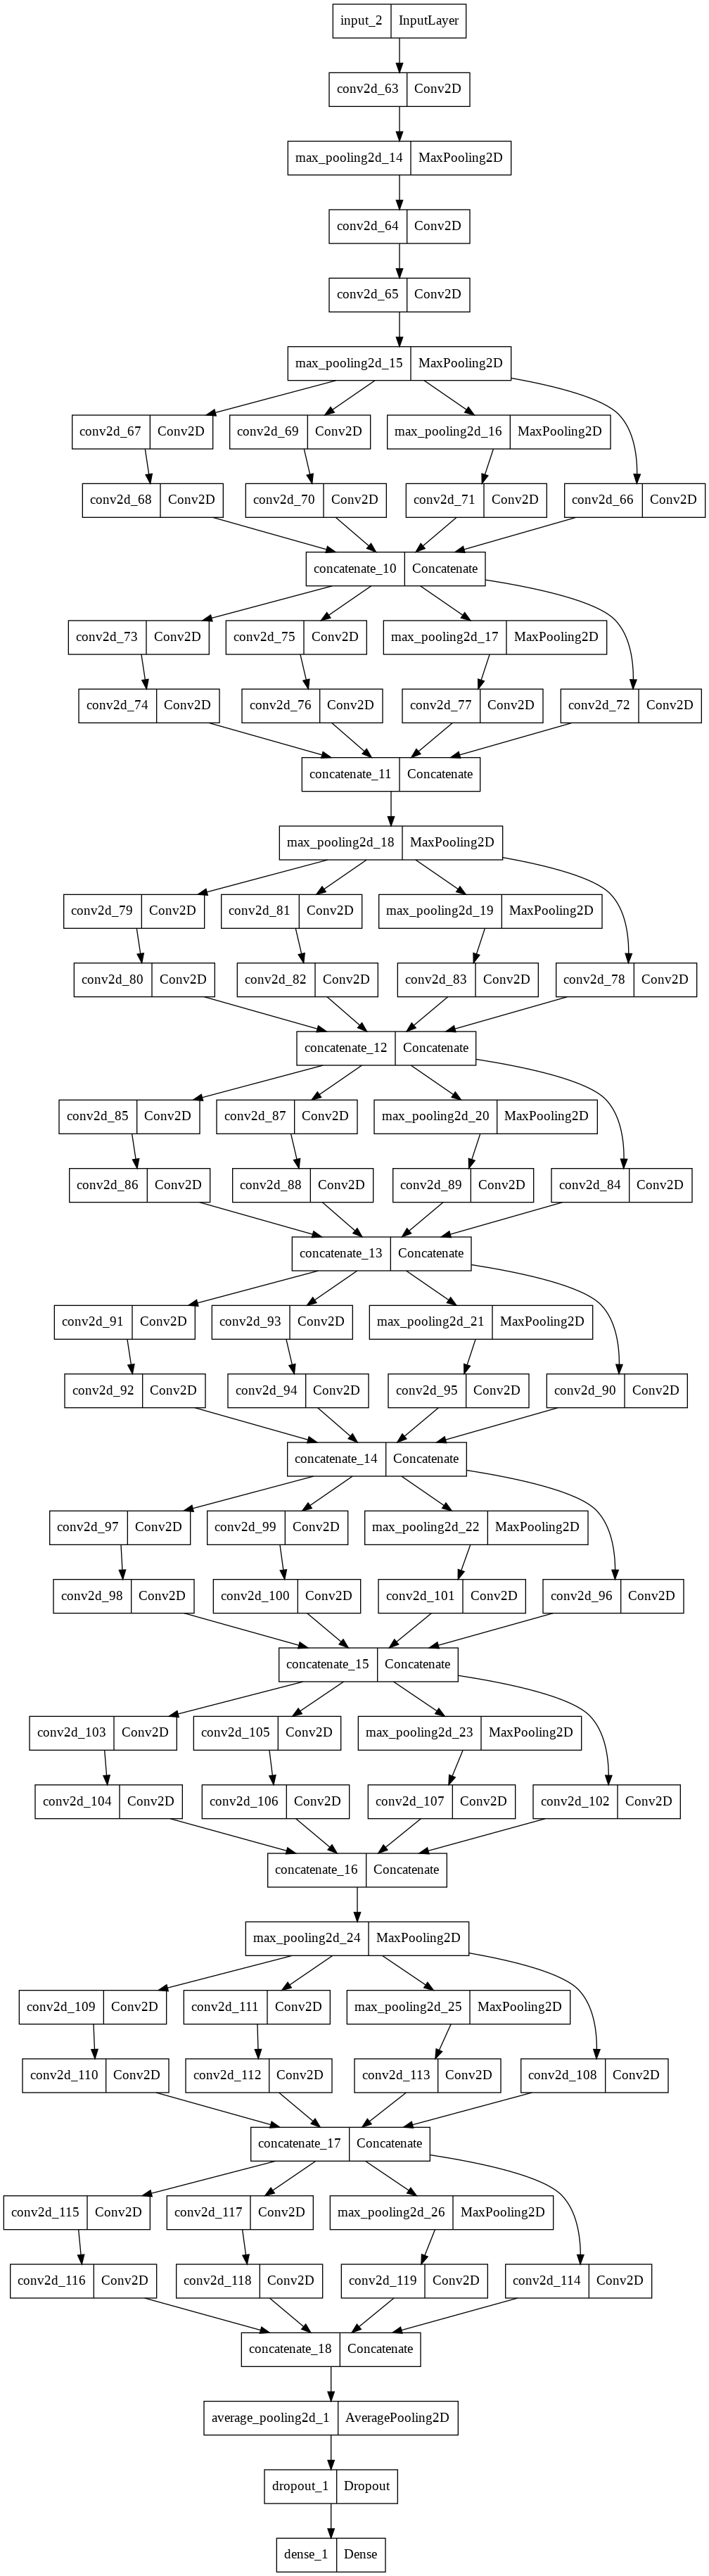

In [10]:
utils.plot_model(googlenet)

That's it about GoogLeNet. Something that we didn't talk about, GoogLeNet used something called Local Response Normalization as a hack to train this deep network. But it's no longer used to day. The better way to train deep neural networks is to use batch normalization, but it was revealed a year after GoogLeNet in 2015. Batch normalization is still used to day when it comes to training very large networks. 

<a name='5'></a>
## 5. Final Notes

GoogLeNet was a groundbreaking architecture, not just because it won the ImageNet classification and detection challenge but also because it introduced a new approach for designing computational efficient convnet architectures that can run in wide variety of low inference devices such as mobile phones and edge devices. 

The main building block of GoogLeNet is inception module. Inception is made of 4 parallel paths whose outputs are concatenated together. Each path extracts features from the input image using convolutional layers. 1x1 convolution is often used for reducing or restoring the channel dimension.

GoogLeNet inception module inspired other powerful convnet architectures that we will see later such as Residual Networks(ResNet).

## [BACK TO TOP](#0)